# Introduction

Set tests are a powerful approach for association testing between groups of genetic variants and quantitative traits.
In this tutorial we demonstrate how to use set tests within the LIMIX framework to test for gene-context interactions (iSet).

# iSet

As we show in this tutorial, iSet can be applied for interaction analysis in two data designs:
* [complete design](#Complete-design), where all individuals have been phenotyped in each context
* [stratified design](#Stratified-design), where each individual has been phenotyped in only one of the two contexts

## Quick Start

iSet uses the same tools for preprocessing as the ones used for mtSet.

0. Our software depends on [Plink](https://www.cog-genomics.org/plink2) version 1.9 (or greater) for preprocessing. Please, make sure you have it before proceeding.

1. Download and install Limix
```bash
git clone --depth 1 https://github.com/PMBio/limix.git
pushd limix
python setup.py install
popd
```

2. Download tutorial
```bash
git clone --depth 1 https://github.com/PMBio/limix-tutorials.git
cd limix-tutorials/mtSet
python download_examples.py
cd data
mkdir out
ls 1000g/
```

3. Set some handy shell variables
```bash
BFILE=1000g/chrom22_subsample20_maf0.10
CFILE=out/chrom22
PFILE=1000g/pheno
WFILE=out/windows
NFILE=out/null
WSIZE=30000
RESDIR=out/results
OUTFILE=out/final
IFILE=1000g/indicator.csv
```

4. Preprocess and phenotype simulation
```bash
# Kinship matrix estimation
mtSet_preprocess --compute_covariance --bfile $BFILE --cfile $CFILE 
# Fitting the null model and assigning the markers to windows
mtSet_preprocess --precompute_windows --bfile $BFILE --wfile $WFILE --window_size $WSIZE --plot_windows
```

5. Analyzing the genotypes
    - Complete design
```bash
# notice the lack of IFILE
iSet_analyze --bfile $BFILE --cfile $CFILE --pfile $PFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 10
```

    - Stratified design
```bash
iSet_analyze --bfile $BFILE --cfile $CFILE --pfile $PFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 10 --ifile $IFILE
```

6. Postprocess
```bash
iSet_postprocess --resdir $RESDIR --outfile $OUTFILE --manhattan_plot
```


## Complete design

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts. iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design). We will here see first an application of iSet for analysis of complete designs, and then an application for the analysis of stratified design in the next section.

### Setting up

In [1]:
# activiate inline plotting
%matplotlib inline

from download_examples import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix
from limix.iSet.iset import fit_iSet
import pandas as pd

In [2]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

In [3]:
# base name for bed, bim and fam
bfile = './data/1000g/chrom22_subsample20_maf0.10'

### Split genotypes into regions

In [4]:
from limix.mtSet.core import plink_reader

In [5]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [6]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method `splitGeno` allows to define the regions that will then considered for the analysis with iSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| __method__      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| __size__      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| __minSnps__      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| __maxSnps__      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| __cache__       | False | bool | If true, it activates the caching |
| __out\_dir__     | './cache' | str | outdir of the cache file |
| __fname__       | None | str | Name of the file |
| __rewrite__     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [7]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


### Apply

In [8]:
# import phenotype and sample relatedness
pheno_file = './data/1000g/pheno.phe'
sample_relatedness_file = './data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)[:,:2]
R = sp.loadtxt(sample_relatedness_file)

In [9]:
# compute eigenvalues and eigenvectors of the sample relatedness matrix
Sg, Ug = scipy.linalg.eigh(R+1e-4*sp.eye(R.shape[0])) # these are needed for the full mtSet model

In [10]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [15]:
n_wnds = 10 # only 10 windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
df = pd.DataFrame()
df0 = pd.DataFrame()
import time

for wnd_i in range(n_wnds):
    t0 = time.time()
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)
    
    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
    Xr-= Xr.mean(0)
    Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])
    
    _df, _df0 = fit_iSet(Y, Ug=Ug, Sg=Sg, Xr=Xr)
    df  = df.append(_df)
    df0 = df0.append(_df0)
    print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16025000-16075000) - 21 snps
Elapsed: 15.8046529293
.. window 1 - (22, 16050000-16100000) - 23 snps
Elapsed: 18.6462008953
.. window 2 - (22, 16125000-16175000) - 7 snps
Elapsed: 14.3644728661
.. window 3 - (22, 16225000-16275000) - 9 snps
Elapsed: 15.3939990997
.. window 4 - (22, 16250000-16300000) - 16 snps
Elapsed: 17.4365749359
.. window 5 - (22, 16275000-16325000) - 12 snps
Elapsed: 16.4648599625
.. window 6 - (22, 16325000-16375000) - 5 snps
Elapsed: 18.7126791477
.. window 7 - (22, 16350000-16400000) - 5 snps


KeyboardInterrupt: 

The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC and information about convergence

In [32]:
df

,mtSet LLR,iSet LLR,iSet-het LLR,Persistent Var,Rescaling-GxC Var,Heterogeneity-GxC var,Converged
0,6.861452e-01,1.355344e-01,9.473803e-05,5.629045e-03,1.232303e-03,1.360568e-04,1.0
0,6.696768e-01,1.124126e-01,5.509369e-02,6.200410e-03,2.832236e-04,4.398604e-03,1.0
0,-3.961816e-09,1.233456e-07,1.226718e-07,7.586155e-12,8.896655e-12,5.222866e-14,1.0
0,2.359830e+00,1.891169e+00,3.018965e-08,8.217359e-03,1.179826e-02,4.764017e-13,1.0
0,1.445056e+00,1.425267e+00,1.702829e-07,5.358896e-03,8.962482e-03,4.162493e-12,1.0
0,-6.795801e-09,1.293916e-07,1.271491e-07,1.637149e-11,2.355878e-12,4.018054e-12,1.0
0,-4.030488e-08,1.341367e-07,1.333494e-07,3.045545e-11,5.935558e-11,1.092629e-11,1.0
0,-6.048992e-09,1.548281e-07,1.547081e-07,7.019006e-12,1.727846e-11,2.873181e-12,1.0
0,1.862853e-01,1.404531e-01,2.273234e-02,3.094510e-03,2.436964e-03,1.300229e-03,1.0
0,9.830342e-02,9.830421e-02,1.228078e-07,1.584804e-03,2.020737e-03,2.559616e-11,1.0


The dataframe df0 contains log likelihood ratios when data are from the null. These are necessary to iSet to calculate P values.

In [33]:
df0

,iSet LLR0,iSet-het LLR0,mtSet LLR0
0,1.360521e+00,-7.355845e-07,2.220135e-01
1,2.759036e-01,7.833876e-08,-1.774329e-07
2,1.214048e-01,8.048272e-08,2.850607e-01
3,4.126475e-01,-1.027745e-07,3.282828e-01
4,1.887856e-01,2.042060e-08,3.522579e-01
5,3.751626e-01,6.228377e-07,5.218640e-01
6,8.386440e-01,-7.174253e-08,3.012096e+00
7,4.969153e-01,1.500001e-06,-2.697449e-07
8,1.245288e+00,1.624942e-07,1.893771e+00
9,3.641889e-01,-7.848695e-08,6.988932e-01


### Variance Component Plot

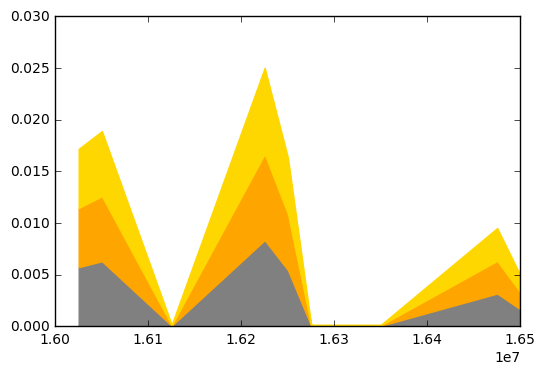

In [12]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
pl.fill_between(split.wnd_pos[:n_wnds,1], 0, df['Persistent Var'].values, color='gray')
pl.fill_between(split.wnd_pos[:n_wnds,1], df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(split.wnd_pos[:n_wnds,1], nohet_var, tot_var, color='Gold')

### P-values

Empirical P values are obtained from a relatively small number of genome-wide permutations by pooling across all conisdered steps.

In [13]:
from limix.mtSet.core.iset_utils import calc_emp_pv_eff
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = calc_emp_pv_eff(df[test+' LLR'].values, df0[test+' LLR0'].values)

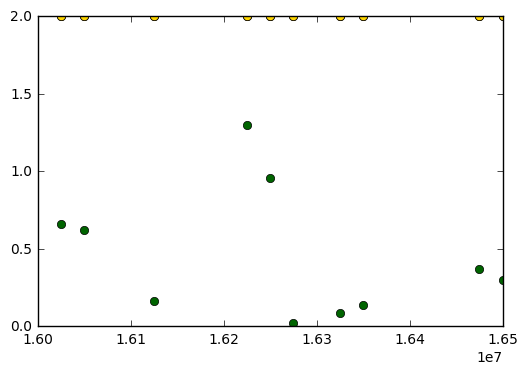

In [14]:
#makes a manhattan plot
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')

## Stratified design

iSet is an extension of mtSet that allows to test for polygenic interactions with environment or other contexts.
iSet can be applied in designs where all individuals have been phenotyped in each context (complete design) as well as for populations that have been stratified by a context variable (stratified design).
We will here see application of iSet for analysis of stratified designs.

### Setting up

In [16]:
# activiate inline plotting
%matplotlib inline

from download_examples import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix
from limix.mtSet.iset import fit_iSet
import pandas as pd

In [17]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

In [18]:
# base name for bed, bim and fam
bfile = './data/1000g/chrom22_subsample20_maf0.10'

### Split genotypes into regions

In [19]:
from limix.mtSet.core import plink_reader

In [20]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [21]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method `splitGeno` allows to define the regions that will then considered for the analysis with iSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| __method__      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| __size__      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| __minSnps__      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| __maxSnps__      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| __cache__       | False | bool | If true, it activates the caching |
| __out\_dir__     | './cache' | str | outdir of the cache file |
| __fname__       | None | str | Name of the file |
| __rewrite__     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [22]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


### Apply

In [23]:
# import phenotype and sample relatedness
pheno_file = './data/1000g/pheno.phe'
sample_relatedness_file = './data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)[:,:1]
R = sp.loadtxt(sample_relatedness_file)
print(Y.shape)

(274, 1)


In [24]:
# let's suppose the first half of the individuals are phenotyped in context A and
# the second half on context B
Ie = sp.arange(R.shape[0])<0.5*R.shape[0]

In [25]:
# corrects for population structure using the first 10 PCs of the relatedness matrix
S_R, U_R = scipy.linalg.eigh(R+1e-4*sp.eye(R.shape[0])) # these are needed for the full mtSet model
covs = sp.concatenate([U_R[:,-10:], sp.ones([U_R.shape[0], 1])], 1)

In [26]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [27]:
n_wnds = 10 # only 10 windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
df = pd.DataFrame()
df0 = pd.DataFrame()
import time
t0 = time.time()
for wnd_i in range(n_wnds):
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)
    
    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
    Xr-= Xr.mean(0)
    Xr/= Xr.std(0)
    Xr/= sp.sqrt(Xr.shape[1])
    
    _df, _df0 = fit_iSet(Y[:,[0]], Xr=Xr, covs=covs, n_perms=10, Ie=Ie, strat=True)
    df  = df.append(_df)
    df0 = df0.append(_df0)
print 'Elapsed:', time.time()-t0

.. window 0 - (22, 16025000-16075000) - 21 snps
fittng iSet
permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
.. window 1 - (22, 16050000-16100000) - 23 snps
fittng iSet
permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
.. window 2 - (22, 16125000-16175000) - 7 snps
fittng iSet
permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
.. window 3 - (22, 16225000-16275000) - 9 snps
fittng iSet
permutation 0 / 10
permutation 1 / 10
permutation 2 / 10
permutation 3 / 10
permutation 4 / 10
permutation 5 / 10
permutation 6 / 10
permutation 7 / 10
permutation 8 / 10
permutation 9 / 10
..

KeyboardInterrupt: 

The dataframe df contains log likelihood ratio scores for the different models, variance component attributable to persistent rescaling-GxC and heterogeneity-GxC and information about convergence.

In [52]:
df

,mtSet LLR,iSet LLR,iSet-het LLR,Persistent Var,Rescaling-GxC Var,Heterogeneity-GxC var,Converged
0,1.253016e+00,2.536109e-01,1.431984e-01,2.688312e-02,7.333731e-03,1.188360e-02,1.0
0,1.046720e+00,1.151325e-01,9.235410e-02,2.349201e-02,3.715896e-03,1.198250e-02,1.0
0,-7.773338e-12,-4.703793e-12,-7.574386e-12,3.825724e-14,2.680818e-15,1.386274e-14,1.0
0,5.018209e-01,5.018225e-01,7.699907e-08,1.309366e-03,1.511329e-02,1.335997e-11,1.0
0,2.301945e-02,2.302026e-02,7.006940e-08,5.349272e-04,2.259426e-03,6.429277e-14,1.0
0,-1.626164e-07,-1.625444e-07,-1.626098e-07,5.070048e-13,3.452770e-13,2.296414e-14,1.0
0,3.544433e-01,3.472862e-01,-1.232679e-07,6.576218e-03,6.109491e-03,1.819593e-09,1.0
0,-6.524161e-09,-6.384354e-09,-6.511513e-09,1.032236e-12,1.208656e-12,1.005793e-14,1.0
0,2.143352e+00,1.430663e+00,5.423550e-01,2.342530e-02,3.305018e-04,2.340622e-02,1.0
0,9.827811e-01,9.496539e-01,5.507960e-02,1.201311e-02,8.315638e-03,6.524066e-03,1.0


The dataframe df0 contains log likelihood ratios when data are from the null.
These are necessary to iSet to calculate P values.

In [53]:
df0

,iSet LLR0,iSet-het LLR0,mtSet LLR0
0,1.157551e-01,3.146971e-02,9.392742e-01
1,3.342326e-01,-4.533675e-09,4.976342e-01
2,7.706905e-02,-2.585153e-09,-6.821210e-13
3,1.942498e-02,7.758158e-01,7.468017e-01
4,1.812480e+00,1.034408e-09,3.012027e+00
5,9.503370e-02,-5.384493e-11,3.597152e-01
6,2.910768e-01,7.354060e-09,1.381280e+00
7,1.562252e-01,-1.258655e-10,1.860364e+00
8,6.399505e-02,-4.213888e-09,2.770256e+00
9,2.809304e-01,3.076389e-08,2.825720e-03


### Variance Component Plot

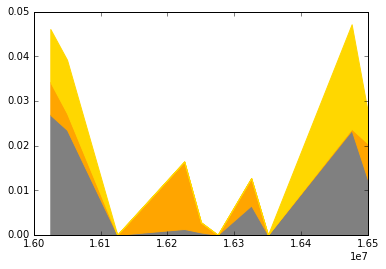

In [54]:
import pylab as pl
tot_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values + df['Heterogeneity-GxC var'].values
nohet_var = df['Persistent Var'].values + df['Rescaling-GxC Var'].values
pl.fill_between(split.wnd_pos[:n_wnds,1], 0, df['Persistent Var'].values, color='gray')
pl.fill_between(split.wnd_pos[:n_wnds,1], df['Persistent Var'].values, nohet_var, color='Orange')
pl.fill_between(split.wnd_pos[:n_wnds,1], nohet_var, tot_var, color='Gold')

### P-values

Empirical P values are obtained from a relatively small number of genome-wide permutations by pooling across all considered steps.

In [55]:
from limix.mtSet.core.iset_utils import calc_emp_pv_eff
#calculate P values for the three tests
for test in ['mtSet', 'iSet', 'iSet-het']:
    df[test+' pv'] = calc_emp_pv_eff(df[test+' LLR'].values, df0[test+' LLR0'].values)

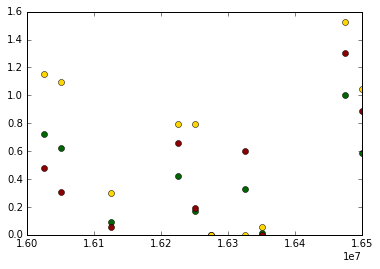

In [56]:
#makes a manhattan plot
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(df['mtSet pv'].values), 'o', color='DarkGreen')
pl.plot(wnd_start, -sp.log10(df['iSet pv'].values), 'o', color='DarkRed')
pl.plot(wnd_start, -sp.log10(df['iSet-het pv'].values), 'o', color='Gold')

## Running analysis

Once the preprocessing step has been used to obtain the genetic relatedness matrix, to fit the null model and to identify the genetic regions to be considered in the analysis, the set test can be run by the following analysis script:

```bash
iSet_analyze --bfile bfile --cfile cfile --pfile pfile --nfile nfile --wfile wfile --ffile ffile --minSnps minSnps --start_wnd start_wnd --end_wnd end_wnd --resdir rdir --trait_idx traitIdx --ifile $IFILE --n_perms 10
```

where

- __bfile__ is the base name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).
- __cfile__ is the base name of the covariance matrix file. The script requires the files: __cfile__.cov containing the the genetic relatedness matrix, __cfile__.cov.id containing the corresponding sample identifiers, __cfile__.cov.eval and __cfile__.cov.evec containing the eigenvalues and eigenvectors of the matrix. If __cfile__ is not set, the relatedness component is omitted from the model.
- __pfile__ is the base name of the phenotype file. The script requires the file __pfile__.phe containing the phenotype data.
- __nfile__ is the base name of the null model file. The script requires the file __nfile__.p0 containing the optimal null model parameters. If covariates are set, it also requires the file __nfile__.f0.
- __wfile__ is the base name of the file containing the windows to be considered in the set test. The script requires the file __wfile__.wnd.
- __ffile__ is the name of the file containing the covariates. Each covariate is saved in one column.
- __perm__ is the seed used when permuting the genotypes. If the option is not specified then no permutation is considered.
- __start\_wnd__ is the index of the start window
- __end\_wnd__ is the index of the end window
- __minSnps__ if set only windows containing at least minSnps are considered in the analysis
rdir is the directory to which the results are exported. The results are exported in the folder rdir/perm if a permutation seed has been set, otherwise in the folder rdir/test. The output file is named - __start\_wnd\_endwnd__.res and contains results in the following format: window index, chromosome, start position, stop position, index of startposition, number of SNPs and log likelihood ratio.
- __rdir__ is the directory to which the results are exported. The results are exported in the folder rdir/perm if a permutation seed has been set, otherwise in the folder rdir/test. The output file is named __start\_wnd\_end\_wnd__.res and contains results in the following format: window index, chromosome, start position, stop position, index of startposition, number of SNPs and log likelihood ratio.
- __trait\_idx__ can be used to specify a subset of the phenotypes. If more than one phenotype is selected, the phenotypes have to be seperated by commas. For instance `--trait_idx` 3,4 selects the phenotypes saved in the forth and fifth column (indexing starts with zero).
Notice that phenotypes are standardized prior to model fitting.
- __ifile__ is the file path to a csv file containing an indicator (True or False) for each sample, implying stratified design if given.

## Postprocessing

After running iSet, the following script can be used to merge the result files and estimate the p-values (p-values are obtained by a parametric fit of the test statistics): 

```bash
iSet_postprocess --resdir resdir --outfile outfile --manhattan_plot --strat
```

where 
* __resdir__ is a pointer to the folder containing the result files of the analysis.
* __outfile__ is the prefix of the two output files.
__outfile__.perm lists the test statistics (first column) and p-values (second column) of the permutated windows
__outfile__.test contains the (index, chromosome, start position, stop position, SNP index, number of SNPs, test statistics and p-value) of each window. Each window is saved in one row.
* __manhattan\_plot__ is a flag. If set, a manhattan plot is saved in __outfile__.manhattan.jpg (default: False).
* __strat__ is a boolean flag that indicates stratified design when used.

# Developers

- Francesco Paolo Casale (<casale@ebi.ac.uk>)
- Barbara Rakitsch (<rakitsch@ebi.ac.uk>)
- Danilo Horta (<horta@ebi.ac.uk>)
- Oliver Stegle (<stegle@ebi.ac.uk>)

# References

[1] Genomes Project, C. et al. An integrated map of genetic variation from 1,092 human genomes. Nature 491, 56-65 (2012).